In [ ]:
import os
os.environ["NUMBA_THREADING_LAYER"] = "omp"

import sys
# if 'google.colab' in sys.modules:
#     !pip --quiet install open-atmos-jupyter-utils
#     from open_atmos_jupyter_utils import pip_install_on_colab
#     pip_install_on_colab('PyMPDATA-examples')
# !pip install PyMPDATA
# !pip install --quiet pint

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

import tsunami_symulation as ts


\title{Symulacja przejścia fali tsunami przez stok kontynentalny}
\author{Karol Bizoń}
\date{3 grudnia 2025}

\maketitle

# Wstęp

Przeprowadzono symulację przejścia fali tsunami przez stok kontynentalny. W tym celu wykorzystano równania płytkiej wody, zaimplementowane przy pomocy pakietu pyMPDATA. Wszytskie wykorzystane klasy i funkcje znajdują się w pliku "tsunami_symulation.py". Stosunek kroków czasowych wylicza się na podstawie przewidywanej prędkości fali i siatki przestrzennej tak, aby wartość liczby Couranta, dla przewidywanej prędkości, była równa 0.4. Za powyższe odpowiada funkcja "calc\_dt\_over\_dxdy\_and\_g". W oblczeniach numerycznych krok czasowy jest wyrażany w minutach, a przestrzenny w kilometrach. 

# Warunki symulacji

Bathymatria oraz głębokość oceanu, z uwzględnieniem zaburzenia, generowane są odpowiednio poprzez funkcje "generate\_bathymetry" oraz "make_h_initial". 

Struktura dna imituje występujące powszechnie przejście pomiędzy płytą kontynentalną, a oceaniczną. W analizowanym przypadku szelf kontynentalny o głębokości 300 m sięga 150 km wgłąb oceanu, a następnie przechodzi w stok o długości 150 km. Basen oceaniczny ma głębokość równą 6 km.  

Wprowadzone zaburzenie odpowiada generacji fali tsunami w wyniku uskoku tektonicznego, w odległości 600 km od brzegu. W analizowanym przypadku uskok spowodował podniesienie się części dna (od strony brzegu) o 7 m oraz spadek o 4 m. Powstałe zaburzenie obejmuje obszar rozciągający się na 200 km w kierunku równoległym i 50 km w kierunku prostopadłym do brzegu i jest reprezentowane jako suma dwóch funkcji Gaussa.

dx = 1.00 km, dy = 1.00 km, dt = 0.03000, dt_over_dxy = 0.03000, 0.03000


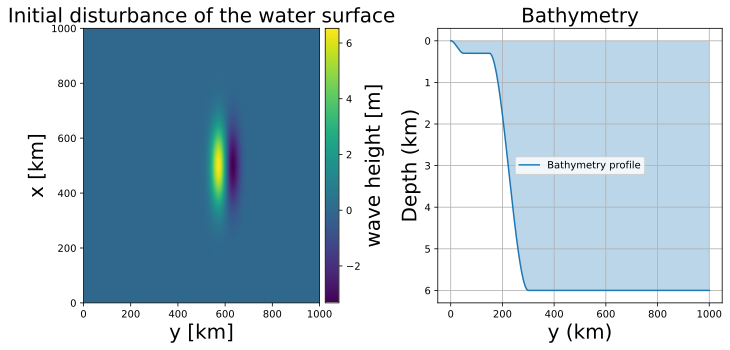

In [ ]:
grid = (1001, 1001)
outfreq = 20
L_km = 1000.0
shelf_end=150
slope_end=300
v_tsunami = 800.0

dt_over_dxy, dt, dx_km, dy_km, g = ts.calc_dt_over_dxdy_and_g(grid=grid, L_km=L_km, v_tsunami_km_per_h=v_tsunami, C=0.4)

bathymetry, X, Y, depth_y = ts.generate_bathymetry(
    grid = grid, x_width=L_km, y_width=L_km, depth_deep=6.0, depth_shelf=0.3,
    y_shelf_start=50, y_shelf_end=150, y_slope_end=300, draw_profile=False,
)

h_initial, vh_initial, uh_initial = ts.make_h_initial(
    bathymetry=bathymetry, X=X, Y=Y, uplift_amp_m = 7.0, subsidence_amp_m = 4.0,
    x_frac = 0.5, x_width_km = 200.0, y_frac = 0.6, y_width_km = 50.0, draw_profile=False,
)

In [ ]:
output1 = ts.ShallowWaterEquationsIntegrator(
    h_initial=h_initial, bathymetry=bathymetry, uh_initial=uh_initial, vh_initial=vh_initial
)(
    nt=2800,
    g=g,
    dt_over_dxy=dt_over_dxy,
    outfreq=outfreq
)

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x76eddacc45d0>>
Traceback (most recent call last):
  File "/home/karol/miniconda3/envs/notebook-env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
# # with open("tsunami_output_1001.npy", "wb") as f:
# #     np.save(f, output)
# with open("tsunami_output_1001.npy", "rb") as f:
#     output1 = np.load(f, allow_pickle=True).item()

## Diagram czasoprzestrzenny

Rozchodzenie się fali w kierunku prostopadłym do brzegu przedstawiono na diagramie czasoprzestrzennym (rys. 1). Fala przemieszczając się przez basen oceaniczny, nie zmienia znacząco swoich parametrów, tj. dlugości, wysokości, prędkości. Przy przechodzeniu przez stok kontynentalny następuje wypiętrzenie się fali, wraz ze zmiejszeniem jej długości oraz wzrostem prędkości. Po osiągnięciu szelfu kotynentalnego paramtry na powrót się stabilizują. 

Do stabilnych obszarów czasoprzestrzeni dopasowano prostą, na podstwie której wyznaczono średnią prędkość fali w obszarze szelfu kontynentalnego i basenu oceanicznego.

$$ v_{\text{szelf}} = 195.8~\text{km/h} $$
$$ v_{\text{basen}} = 885.4~\text{km/h} $$

Teoretyczne prędkości fali tsunami można przewidzieć, kożystając ze wzoru:

$$v = \sqrt{gh}.$$

gdzie $h$ to głębokość oceanu.

Dla badanych głębokości oczekiwanio więc wartości odpowiednio dla szelfu 197.18 km/h i dla basenu 881.8 km/h. Różnicę względne wynoszą $0.7\%$ dla szelfu i $0.4\%$, co świadczy o poprawności symulacji.

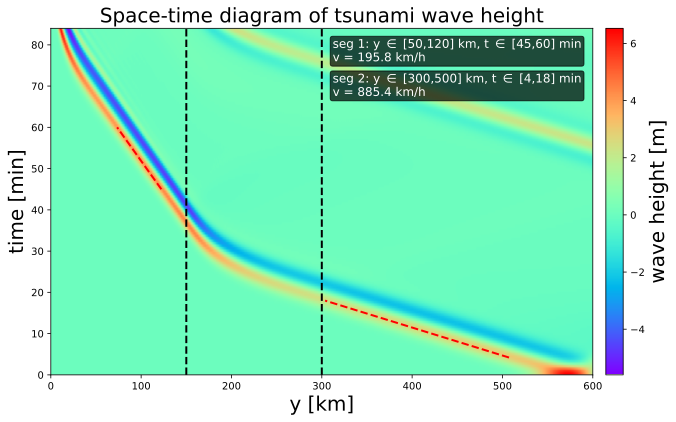

In [4]:
ts.plot_space_time_diagram(
    output=output1,
    bathymetry=bathymetry, 
    y_coords=np.linspace(0, L_km, bathymetry.shape[1]), 
    dt=dt, 
    outfreq=outfreq, 
    slope_end=slope_end, 
    shelf_end=shelf_end,
    pos_segments=[
        (50, 120,  45, 60), 
        (300, 500, 4, 18)
    ],
    cmap="rainbow",
)

Rys.1 Diagram czasoprzestrzenny wysokości fali tsunami z prędkościami wyznaczonymi na podstawie dopasowania prostej w zaznaczonych obszarach.

## Wysokość tsunami w zależności od czasu i głębokości

Zbadano zależność wysokości fali w funkcji czasu, wraz z porównaniem z bathymetrią (rys. 2). Na głębokim ocenanie wysokość fali osiąga niecałe 3 metry. Podczas przekraczania stoku kontynentalnego wysokość rośnie do około 4.5 metra. Natępnie poruszając się po plaskim szelfie wysokość fali nieznacznie maleje do 4 m, po czym rośnie znacząco przy zbliżaniu się do plaży. 

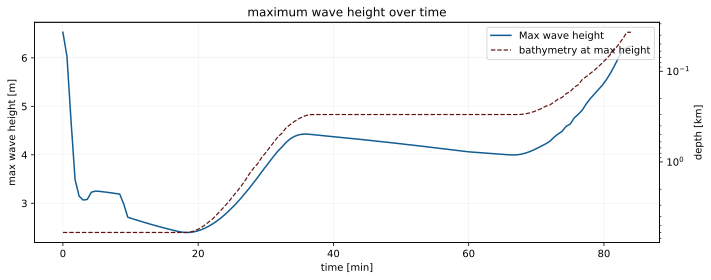

In [4]:
ts.animate_cross_section_y(
    output=output1,
    bathymetry=bathymetry,
    y_coords=np.linspace(0, L_km, bathymetry.shape[1]),
    dt=dt,
    outfreq=outfreq,
    shelf_end=shelf_end,
    slope_end=slope_end,
    x_index=None,
    create_animation=False,
)

Rys. 2 Wysokość fali tsunami w funkcji czasu dla siatki (1001 $\times$ 1001).

## Analiza zbieżności

Wyniki osiągnięte dla gęstości siatki (1001 $\times$ 1001) porównano z siatką (1201 $\times$ 1201) (rys. 3). Interwał czasowy po jakim fala dotarła do stoku wynosi 20 minut. W okolicach 35 minuty wysokość osiąga maksimum przy wchodzeniu na szelf kontynentalny. Dla obu gęstości siatki maksimum wysokości wynosi około 4.5 metra. Prędkości uzyskane dla siatki (1201 $\times$ 1201) wyniosły odpowiednio dla szelfu 194.9, a dla basenu 888.3 km/h, co zgadza się z wartościami dla siatki (1001 $\times$ 1001).

Niezgodności zaobserowowano dla wysokości fali na szelfie. Dla mniej gęstej siatki wysokość fali spada szybciej, osiągając wartość 4 metrów podczas, gdy dla gęstszej siatki minimum nie spada poniżej 4 metrów. Dla siatki (601 $\times$ 601) wysokość fali spadała do około 3.5 metra, podczas gdy pozostałe parametry pozostawały zgodne. Zjawisko to wynika z faktu, że skale przestrzenne fali tsunami (długość fali) zmniejszają się w płytszej wodzie, co wymaga gęstszej siatki numerycznej. Rozwiązaniem tego problemu byłoby zastosowanie zagęszczonej siatki w obszarze szelfu, czego nie zrealizowano ze względu na ograniczenia sprzętowe.

Niemniej zbieżność metody można uznać za zadowalającą.

In [ ]:
grid = (1201, 1201)
outfreq = 25
L_km = 1000.0
shelf_end=150
slope_end=300
v_tsunami = 800.0

dt_over_dxy, dt, dx_km, dy_km, g = ts.calc_dt_over_dxdy_and_g(grid=grid, L_km=L_km, v_tsunami_km_per_h=v_tsunami, C=0.4)

bathymetry, X, Y, depth_y = ts.generate_bathymetry(
    grid = grid, x_width=L_km, y_width=L_km, depth_deep=6.0, depth_shelf=0.3,
    y_shelf_start=50, y_shelf_end=150, y_slope_end=300, draw_profile=False,
)

h_initial, vh_initial, uh_initial = ts.make_h_initial(
    bathymetry=bathymetry, X=X, Y=Y, uplift_amp_m = 7.0, subsidence_amp_m = 4.0,
    x_frac = 0.5, x_width_km = 200.0, y_frac = 0.6, y_width_km = 50.0, draw_profile=False,
)

output = ts.ShallowWaterEquationsIntegrator(
    h_initial=h_initial, bathymetry=bathymetry, uh_initial=uh_initial, vh_initial=vh_initial
)(
    nt=3360, g=g, dt_over_dxy=dt_over_dxy, outfreq=outfreq
)

# with open("tsunami_output_1201.npy", "rb") as f:
#     output = np.load(f, allow_pickle=True).item()

ts.animate_cross_section_y(
    output=output, bathymetry=bathymetry, y_coords=np.linspace(0, L_km, bathymetry.shape[1]), dt=dt,
    outfreq=outfreq, shelf_end=shelf_end, slope_end=slope_end, x_index=None, create_animation=False,
)

dx = 0.83 km, dy = 0.83 km, dt = 0.02500, dt_over_dxy = 0.03000, 0.03000


Rys. 3 Wysokość fali tsunami w funkcji czasu dla siatki (1201 $\times$ 1201).

## Podsumawanie


W pracy przeprowadzono symulację przejścia fali tsunami przez stok kontynentalny przy użyciu równań
płytkiej wody zaimplementowanych w pakiecie \texttt{pyMPDATA}. Analizę wykonano dla realistycznej
bathymetrii obejmującej basen oceaniczny, stok kontynentalny oraz szelf.

Wyniki pokazały, że w głębokiej wodzie parametry fali pozostają stabilne, natomiast podczas
przekraczania stoku następuje jej wypiętrzenie, skrócenie długości oraz zmiana prędkości.
Wyznaczone prędkości propagacji fali $v_{\text{basen}} \approx 885$ km/h,
$v_{\text{szelf}} \approx 196$ km/h są zgodne z wartościami teoretycznymi opartymi na
zależności $v = \sqrt{gh}$.

Wysokość fali wynosi około 3 m w basenie oceanicznym, po czym rośnie do
około 4.5 m na stoku, a następnie stabilizuje się na poziomie 4 m na szelfie.
Analiza zbieżności wykazała dobrą stabilność metody numerycznej w obszarze basenu oceanicznego i stoku kontynentalnego.